### xarray wrapping via stream callables?

First, let's use the new callable method...

In [1]:
import numpy as np 
import yt

x_coefficients = (100, 50, 30, 10, 20)
y_coefficients = (20, 90, 80, 30, 30)
z_coefficients = (50, 10, 90, 40, 40)

def my_function(grid, field_name):
    # We want N points from the cell-center to the cell-center on the other side
    x, y, z = (np.linspace(grid.LeftEdge[i] + grid.dds[i]/2, grid.RightEdge[i] - grid.dds[i]/2, grid.ActiveDimensions[i]) for i in (0,1,2))
    r = np.sqrt(((x.d - 0.5)**2)[:,None,None] + ((y.d-0.5)**2)[None,:,None] + ((z.d-0.5)**2)[None, None, :])
    atten = np.exp(-20*(1.1*r**2))
    xv = sum([c * np.sin(2**(1+i) * (x.d*np.pi*2)) for i, c in enumerate(x_coefficients)])
    yv = sum([c * np.sin(2**(1+i) * (y.d*np.pi*2)) for i, c in enumerate(y_coefficients)])
    zv = sum([c * np.sin(2**(1+i) * (z.d*np.pi*2)) for i, c in enumerate(z_coefficients)])
    return atten * (xv[:,None,None] * yv[None,:,None] * zv[None,None,:])

In [2]:
from yt.testing import _amr_grid_index
grid_data = []
for level, le, re, dims in _amr_grid_index:
    grid_data.append({'level': level, 'left_edge': le, 'right_edge': re, 'dimensions': dims, 'density': my_function})
ds = yt.load_amr_grids(grid_data, [32, 32, 32], bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]))

yt : [INFO     ] 2022-09-12 13:38:58,573 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 13:38:58,573 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2022-09-12 13:38:58,574 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:38:58,575 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:38:58,575 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-09-12 13:38:58,698 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:38:58,699 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:38:58,700 Making a fixed resolution buffer of (density) 800 by 800
yt : [INFO     ] 2022-09-12 13:38:58,786 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [WARNING  ] 2022-09-12 13:38:58,799 Plotting ('gas', 'density'): Both positive and negative values. Min = -408740.34151375014 g/cm**3, Max = 408740.34151373204 g/cm**3.
yt : [WARNING  ] 2022-09-12 13:38:58,800 Switching to symlog colorbar scaling.



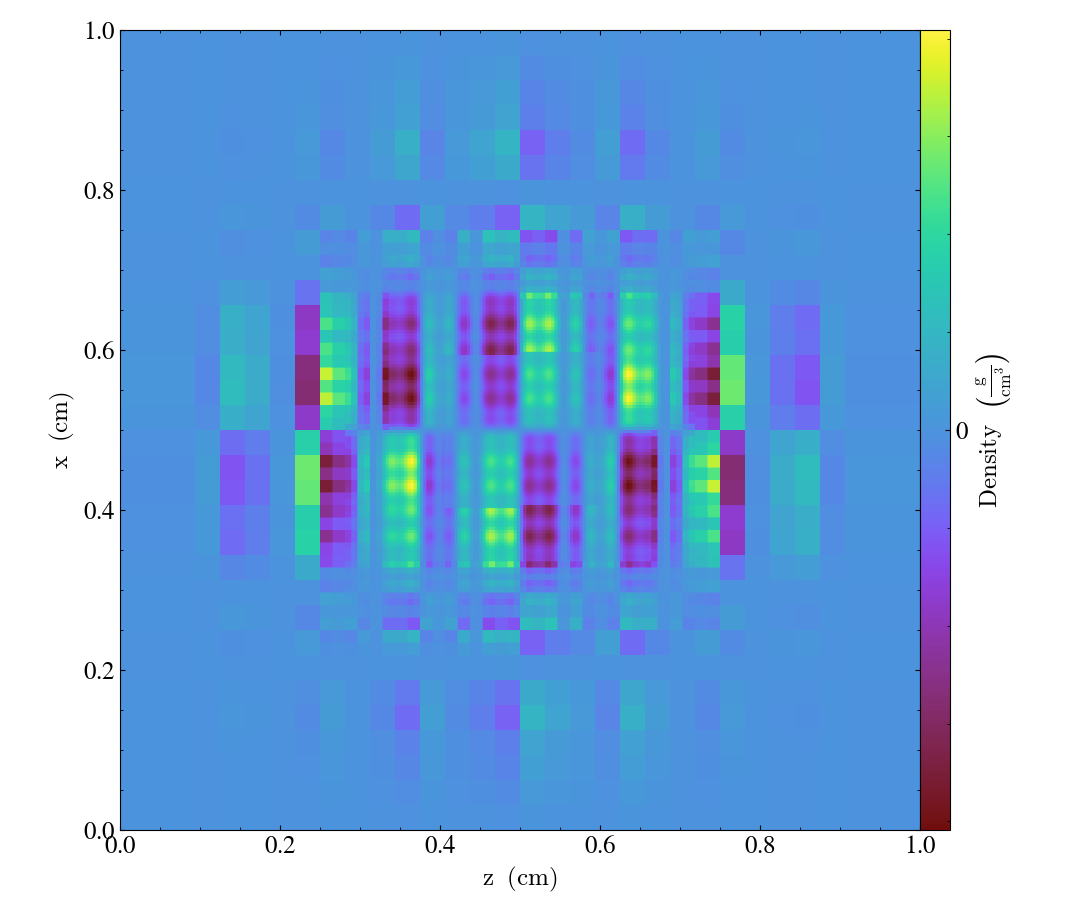

In [3]:
p = ds.r[:, 0.5, :].plot("density").set_log("density", False)

hmmm.... what if load data with chunks from xarray https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html#xarray.open_dataset then in the stream callabel selected indexes, return in mem from those dask arrays. 

if the data were already a zarr, xarry would read into chunks.... 

in yt, how do you do unrefined adjacent chunking of uniform grids? is that what nprocs in load_uniform_grid doing?


In [4]:

shp = (10, 14, 12)
data = {"whatever": (np.random.random(shp), '')}
ds = yt.load_uniform_grid(data,  shp, nprocs=2)

yt : [INFO     ] 2022-09-12 13:38:59,335 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 13:38:59,335 Parameters: domain_dimensions         = [10 14 12]
yt : [INFO     ] 2022-09-12 13:38:59,336 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:38:59,337 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:38:59,337 Parameters: cosmological_simulation   = 0


In [5]:
ds.index.grid_dimensions

array([[10,  7, 12],
       [10,  7, 12]], dtype=int32)

In [6]:
g0 = ds.index.grids[0]
(g0.LeftEdge, g0.RightEdge)

(unyt_array([0., 0., 0.], 'code_length'),
 unyt_array([1. , 0.5, 1. ], 'code_length'))

ya, that's what it does...

In [7]:
ds = yt.load_uniform_grid(data,  shp, nprocs=4)

yt : [INFO     ] 2022-09-12 13:38:59,511 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 13:38:59,512 Parameters: domain_dimensions         = [10 14 12]
yt : [INFO     ] 2022-09-12 13:38:59,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:38:59,513 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:38:59,514 Parameters: cosmological_simulation   = 0


In [8]:
ds.index.grid_dimensions

array([[10,  7,  6],
       [10,  7,  6],
       [10,  7,  6],
       [10,  7,  6]], dtype=int32)

so **if** the xarray.open_dataset used chunks... then doing an xarray selection within a stream callable for the wanted global indices in the xarray-dask array would figure out the underyling chunking and concatenate. So even if xarray and yt chunking were misaligned, that'd be OK?

In [9]:
ds.index.grid_left_edge

unyt_array([[0. , 0. , 0. ],
            [0. , 0. , 0.5],
            [0. , 0.5, 0. ],
            [0. , 0.5, 0.5]], 'code_length')

In [10]:
ds.index.grid_right_edge

unyt_array([[1. , 0.5, 0.5],
            [1. , 0.5, 1. ],
            [1. , 1. , 0.5],
            [1. , 1. , 1. ]], 'code_length')

In [11]:
ds.index.grid_dimensions

array([[10,  7,  6],
       [10,  7,  6],
       [10,  7,  6],
       [10,  7,  6]], dtype=int32)

In [12]:
g0 = ds.index.grids[3]
(g0.LeftEdge, g0.RightEdge)

(unyt_array([0. , 0.5, 0.5], 'code_length'),
 unyt_array([1., 1., 1.], 'code_length'))

In [13]:
g0.ActiveDimensions

array([10,  7,  6], dtype=int32)

In [14]:
g0.start_index

In [15]:
g0.get_global_startindex()

array([0, 7, 6])

# first, loading a xr ds as a single grid...

loading as cartesian for now, neglecting coord order, dds 

In [16]:
import xarray as xr
import yt

In [17]:
def _read_data(handle):
    def _reader(grid, field_name):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        return data.values

    return _reader

fn = "/home/chavlin/hdd/data/yt_data/yt_sample_sets/IRIS/wUS-SH-2010_percent.nc"
xr_handle = xr.open_dataset(fn)
reader = _read_data(xr_handle)

fields = list(xr_handle.data_vars)
shape = xr_handle.data_vars[fields[0]].shape

data = {_: reader for _ in fields}
data.update({"left_edge": [0., 0., 0.], "right_edge": [1., 1., 1.], "dimensions": shape, "level": 0})

grid_data = [data,]

ds = yt.load_amr_grids(grid_data, shape)

yt : [INFO     ] 2022-09-12 13:38:59,929 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 13:38:59,930 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2022-09-12 13:38:59,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:38:59,931 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:38:59,932 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-09-12 13:39:00,003 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:39:00,004 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:39:00,004 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:39:00,005 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:39:00,006 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2022-09-12 13:39:00,020 Plotting ('stream', 'dvs'): Both positive and negative values. Min = -4.920000076294282 dimensionless, Max = 6.090000152588713 dimensionless.
yt : [WARNING  ] 2022-09-12 13:39:00,020 Switching to symlog colorbar scaling.



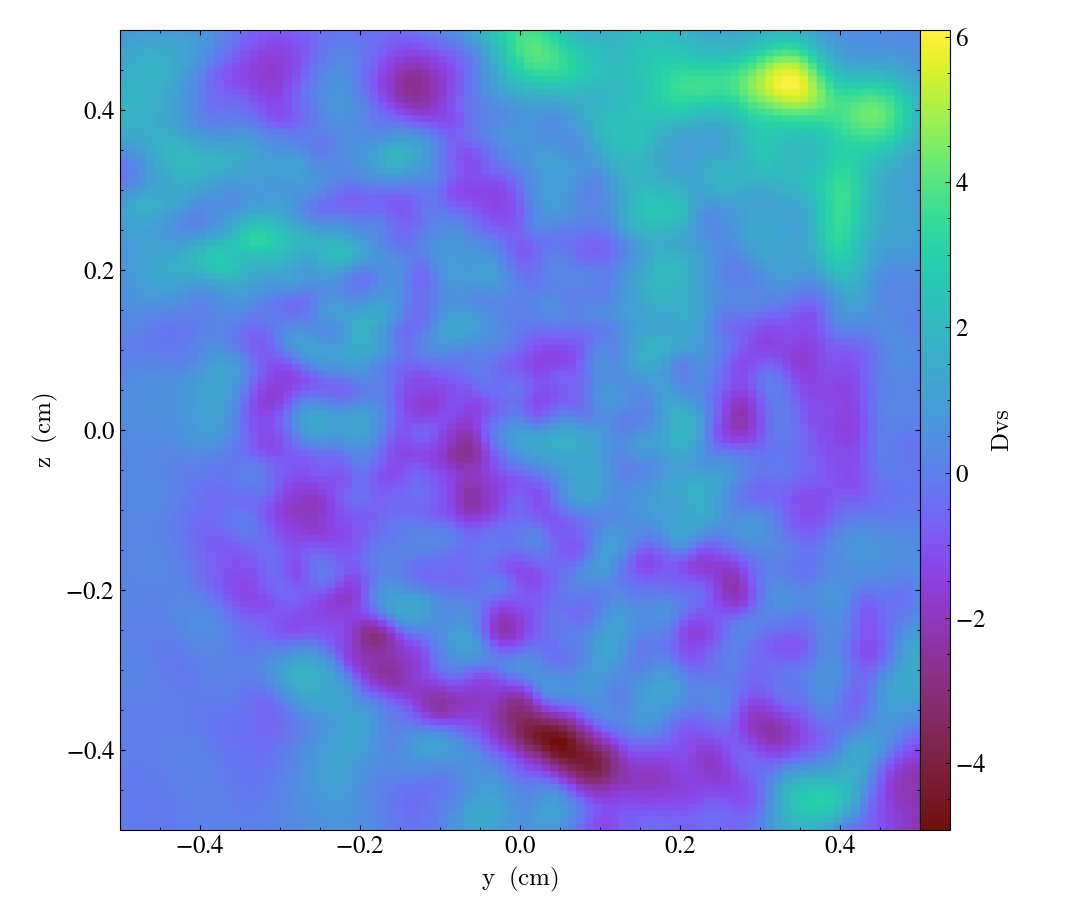

In [18]:
slc = yt.SlicePlot(ds, "x", ("stream", "dvs"))
slc.set_log(("stream", "dvs"), False)

## sampling a chunked dataset without worrying about alignment...

when you do:

xr_handle = xr.open_dataset(fn, chunks=10)  # chunks is a chunksize here, not nchunks

then accessing data returns dask arrays:

In [19]:
print(xr_handle.dvs)

<xarray.DataArray 'dvs' (depth: 19, latitude: 93, longitude: 122)>
[215574 values with dtype=float32]
Coordinates:
  * depth      (depth) float32 60.0 90.0 125.0 160.0 ... 700.0 760.0 820.0 885.0
  * latitude   (latitude) float32 27.5 27.75 28.0 28.25 ... 50.0 50.25 50.5
  * longitude  (longitude) float32 -125.8 -125.5 -125.2 ... -96.0 -95.75 -95.5
Attributes:
    long_name:     Shear Velocity perturbation
    display_name:  dVs (%)
    units:         percent


In [20]:
import dask 
import numpy as np
np.mean(dask.compute(xr_handle.dvs * 2))

0.6403812

In [21]:
xr_handle.dvs.chunksizes

Frozen({})

accessing data still returns dask arrays, but dask/xarray will know how to find the right chunk:

In [22]:
xr_handle.dvs[0:15, 0:10, 0:10]

<xarray.DataArray 'dvs' (depth: 15, latitude: 10, longitude: 10)>
array([[[ 0.  ,  0.  , ...,  0.  ,  0.  ],
        [ 0.  ,  0.  , ...,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  , ...,  0.  ,  0.  ],
        [ 0.  ,  0.  , ...,  0.  ,  0.  ]],

       [[ 0.  ,  0.  , ...,  0.  ,  0.  ],
        [ 0.  ,  0.  , ...,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  , ..., -0.01, -0.01],
        [ 0.  ,  0.  , ..., -0.01, -0.01]],

       ...,

       [[ 0.03,  0.03, ...,  0.  , -0.01],
        [ 0.02,  0.02, ..., -0.03, -0.04],
        ...,
        [-0.11, -0.13, ..., -0.27, -0.29],
        [-0.1 , -0.11, ..., -0.26, -0.28]],

       [[-0.03, -0.05, ..., -0.15, -0.14],
        [-0.05, -0.07, ..., -0.19, -0.18],
        ...,
        [-0.1 , -0.13, ..., -0.34, -0.35],
        [-0.06, -0.08, ..., -0.3 , -0.33]]], dtype=float32)
Coordinates:
  * depth      (depth) float32 60.0 90.0 125.0 160.0 ... 490.0 540.0 590.0 645.0
  * latitude   (latitude) float32 27.5 27.75 28.0 28.25 ... 29.25 29.5 29.75
  * longitude  (longitude) float32 -125.8 -125.5 -125.2 ... -124.0 -123.8 -123.5
Attributes:
    long_name:     Shear Velocity perturbation
    display_name:  dVs (%)
    units:         percent

so we could arbitrarily split up spatial domain grids for yt and not worry how it aligns with the xarray chunking:

In [23]:
from yt.utilities.decompose import decompose_array, get_psize

def _read_data(handle):
    def _reader(grid, field_name, return_dask=False):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        if return_dask:            
            return data        
        return data.values

    return _reader

fn = "/home/chavlin/hdd/data/yt_data/yt_sample_sets/IRIS/wUS-SH-2010_percent.nc"
xr_handle = xr.open_dataset(fn, chunks=10)
reader = _read_data(xr_handle)


fields = list(xr_handle.data_vars)
global_shape = xr_handle.data_vars[fields[0]].shape 

# decompose the grid for yt, ignoring the xarray chunking
n_grid_chunks = 4  # (nprocs in load_uniform_grid)
bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], "float64")

# assuming all fields are the same size
psize = get_psize(np.array(global_shape), n_grid_chunks)
grid_left_edges, grid_right_edges, grid_shapes, slices = decompose_array(
    global_shape, psize, bbox
)

grid_data = []
for gid in range(n_grid_chunks):
    new_grid = {
        "left_edge": grid_left_edges[gid],
        "right_edge": grid_right_edges[gid],            
        "dimensions": grid_shapes[gid],
        "level": 0,
    }
    for field in fields:
        new_grid[field] = reader
        
    grid_data.append(new_grid)

ds = yt.load_amr_grids(grid_data, global_shape)

yt : [INFO     ] 2022-09-12 13:39:00,452 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 13:39:00,453 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2022-09-12 13:39:00,453 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 13:39:00,454 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 13:39:00,454 Parameters: cosmological_simulation   = 0


in this case, the xarray array is split into 260 chunks:

In [24]:
xr_handle.dvs

<xarray.DataArray 'dvs' (depth: 19, latitude: 93, longitude: 122)>
dask.array<open_dataset-a2f497218ba19c79b745b81a1d176891dvs, shape=(19, 93, 122), dtype=float32, chunksize=(10, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 60.0 90.0 125.0 160.0 ... 700.0 760.0 820.0 885.0
  * latitude   (latitude) float32 27.5 27.75 28.0 28.25 ... 50.0 50.25 50.5
  * longitude  (longitude) float32 -125.8 -125.5 -125.2 ... -96.0 -95.75 -95.5
Attributes:
    long_name:     Shear Velocity perturbation
    display_name:  dVs (%)
    units:         percent

while the yt grid is divided into 4 chunks:

In [25]:
len(ds.index.grids)

4

In [26]:
for gid in range(len(ds.index.grids)):
    print(f"grid {gid}")
    for dim in range(3):
        left = ds.index.grid_left_edge[gid][dim].d
        right = ds.index.grid_right_edge[gid][dim].d
        print(f"    dim {dim}: {left}, {right}")

grid 0
    dim 0: 0.0, 1.0
    dim 1: 0.0, 0.49462365591397855
    dim 2: 0.0, 0.5
grid 1
    dim 0: 0.0, 1.0
    dim 1: 0.0, 0.49462365591397855
    dim 2: 0.5, 1.0
grid 2
    dim 0: 0.0, 1.0
    dim 1: 0.49462365591397855, 1.0
    dim 2: 0.0, 0.5
grid 3
    dim 0: 0.0, 1.0
    dim 1: 0.49462365591397855, 1.0
    dim 2: 0.5, 1.0


this means that when yt does a selection from a given grid, the `reader` will read across xarray-dask chunks. For example, 

In [27]:
dvs = reader(ds.index.grids[0], ("stream", "dvs"))

In [28]:
dvs.shape

(19, 46, 61)

To see this explicitly, can use the `return_dask` kwarg (note: this will always be `False` when yt uses this function). To read a field for a single grid:

In [29]:
dvs = reader(ds.index.grids[0], ("stream", "dvs"), return_dask=True)
dvs

<xarray.DataArray 'dvs' (depth: 19, latitude: 46, longitude: 61)>
dask.array<getitem, shape=(19, 46, 61), dtype=float32, chunksize=(10, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 60.0 90.0 125.0 160.0 ... 700.0 760.0 820.0 885.0
  * latitude   (latitude) float32 27.5 27.75 28.0 28.25 ... 38.25 38.5 38.75
  * longitude  (longitude) float32 -125.8 -125.5 -125.2 ... -111.2 -111.0 -110.8
Attributes:
    long_name:     Shear Velocity perturbation
    display_name:  dVs (%)
    units:         percent

more explicitly, let's check the dask chunks returned:

In [30]:
dvs.chunksizes

Frozen({'depth': (10, 9), 'latitude': (10, 10, 10, 10, 6), 'longitude': (10, 10, 10, 10, 10, 10, 1)})

In [31]:
{_: len(dvs.chunksizes[_]) for _ in dvs.chunksizes.keys()}

{'depth': 2, 'latitude': 5, 'longitude': 7}

compared to the whole, 

In [32]:
{_: len(xr_handle.dvs.chunksizes[_]) for _ in xr_handle.dvs.chunksizes.keys()}

{'depth': 2, 'latitude': 10, 'longitude': 13}

so when yt calls the `reader`, it will collapse data across the chunks:

In [33]:
dvs = reader(ds.index.grids[0], ("stream", "dvs"))
dvs.shape

(19, 46, 61)

In [34]:
xr_handle.dvs.shape

(19, 93, 122)

This is easier to see while watching the dask tasks execute:

In [35]:
from dask import distributed

In [36]:
distributed.client?

Type:        module
String form: <module 'distributed.client' from '/home/chavlin/miniconda3/envs/yt_dev/lib/python3.9/site-packages/distributed/client.py'>
File:        ~/miniconda3/envs/yt_dev/lib/python3.9/site-packages/distributed/client.py
Docstring:   <no docstring>


In [37]:
c = distributed.Client(n_workers=2, nthreads=1)

2022-09-12 13:39:01,177 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6v5ex305', purging
2022-09-12 13:39:01,178 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-y79zmng3', purging


In [38]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 6,Total memory: 31.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40469,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 31.20 GiB
Comm: tcp://127.0.0.1:40745,Total threads: 3
Dashboard: http://127.0.0.1:39313/status,Memory: 15.60 GiB
Nanny: tcp://127.0.0.1:35637,


In [39]:
ad = ds.all_data()

In [40]:
dvs = ad[("stream", "dvs")]

the dask client dashboard shows all the reads:

![yt_dask_read_alldata](xr_yt_stream_all_data_read.png)


by supplying a sub-region, yt will initially cull by grid, resulting in fewer dask reads:

In [41]:
le = ds.domain_left_edge
re = ds.domain_center-ds.arr([0.05, 0.05, 0.05], 'code_length')
c = (le + re)/2.0

reg = ds.region(c, le, re)

In [42]:
dvs = reg[("stream", "dvs")]

In this case, yt first culls by grid-region intersection, so only the dask-array chunks contained by the grids are loaded:

![yt_dask_read_smallregion](xr_yt_stream_small_region.png)

sample plots

yt : [INFO     ] 2022-09-12 13:40:10,683 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:40:10,684 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:40:10,685 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:40:10,685 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 13:40:10,687 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800
yt : [WARNING  ] 2022-09-12 13:40:10,720 Plotting ('stream', 'dvs'): Both positive and negative values. Min = -4.920000076294282 dimensionless, Max = 6.090000152588713 dimensionless.
yt : [WARNING  ] 2022-09-12 13:40:10,721 Switching to symlog colorbar scaling.



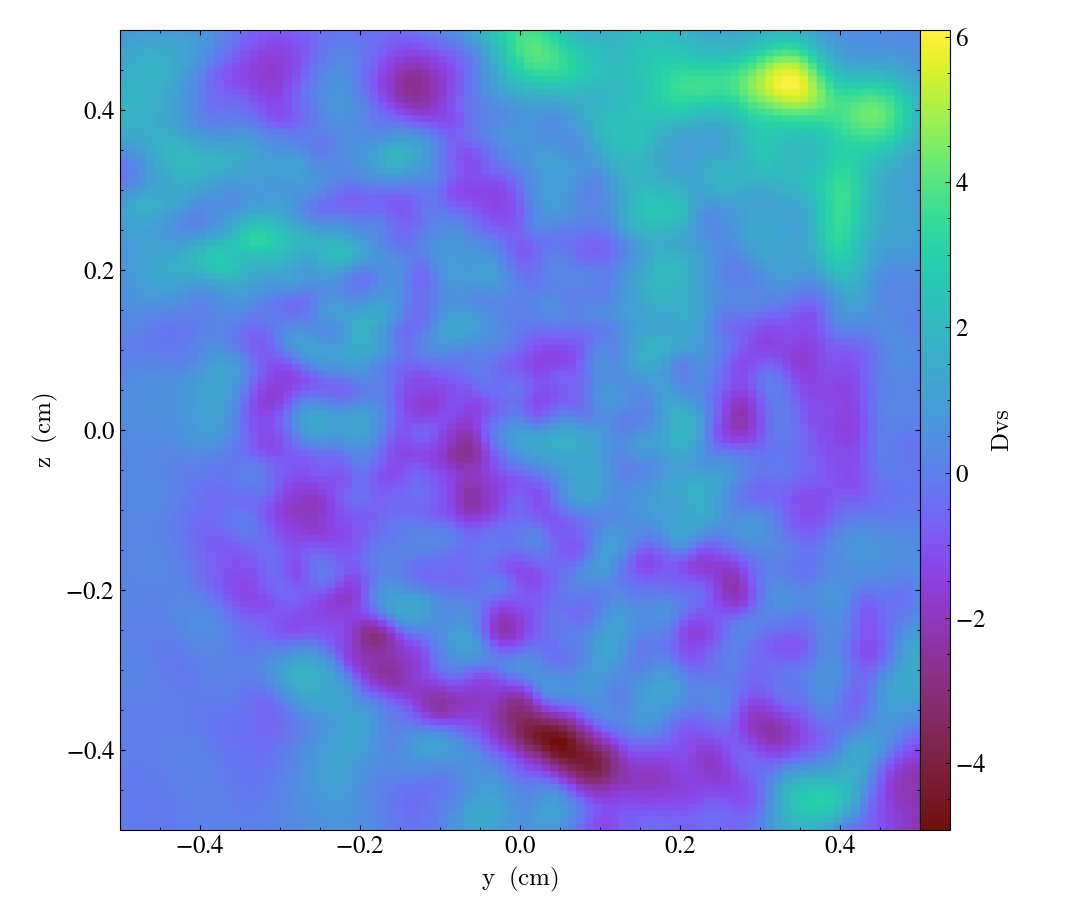

In [43]:
slc = yt.SlicePlot(ds, "x", ("stream", "dvs"))
slc.set_log(("stream", "dvs"), False)

a more complete load (with dds)

## aligning dask-xarray chunks and yt grid objects??

The above example sets the dask-xarray chunks and yt grid chunking separately, which results in some interesting hierarchical culling (yt subselects a grid, dask chunks within the grid are loaded). This does mean, however, that some chunks will be loaded and discarded when they fail the `selector` test. So likely the best performance would come from matching the dask-xarray chunksizes to the yt grid chunking... 

remember that the xarray `chunks` argument is number of elements per chunk (in each direction if an integer)

In [48]:
fn = "/home/chavlin/hdd/data/yt_data/yt_sample_sets/IRIS/wUS-SH-2010_percent.nc"

chunk_size = 50
xr_handle = xr.open_dataset(fn, chunks=chunk_size)
reader = _read_data(xr_handle)

fields = list(xr_handle.data_vars)
global_shape = xr_handle.data_vars[fields[0]].shape 

In [50]:
xr_handle.data_vars[fields[0]].chunks

((19,), (50, 43), (50, 50, 22))

In [65]:
xr_handle.data_vars[fields[0]].size

215574

In [68]:
dvs = xr_handle.data_vars[fields[0]]
dvs.dims

('depth', 'latitude', 'longitude')

In [69]:
dvs.chunksizes

Frozen({'depth': (19,), 'latitude': (50, 43), 'longitude': (50, 50, 22)})

In [62]:
import numpy as np
n_grid_chunks = np.prod([len(xr_handle.data_vars[fields[0]].chunks[i]) for i in range(3)])
n_grid_chunks

6

In [63]:
bbox = np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], "float64")

# assuming all fields are the same size
psize = get_psize(np.array(global_shape), n_grid_chunks)
grid_left_edges, grid_right_edges, grid_shapes, slices = decompose_array(
    global_shape, psize, bbox
)

grid_data = []
for gid in range(n_grid_chunks):
    new_grid = {
        "left_edge": grid_left_edges[gid],
        "right_edge": grid_right_edges[gid],            
        "dimensions": grid_shapes[gid],
        "level": 0,
    }
    for field in fields:
        new_grid[field] = reader
        
    grid_data.append(new_grid)

ds = yt.load_amr_grids(grid_data, global_shape)

yt : [INFO     ] 2022-09-06 15:34:03,959 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-06 15:34:03,959 Parameters: domain_dimensions         = [ 19  93 122]
yt : [INFO     ] 2022-09-06 15:34:03,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-06 15:34:03,961 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-06 15:34:03,961 Parameters: cosmological_simulation   = 0


In [64]:
ds.index.grid_dimensions

array([[19, 31, 61],
       [19, 31, 61],
       [19, 31, 61],
       [19, 31, 61],
       [19, 31, 61],
       [19, 31, 61]], dtype=int32)

right... the yt domain decomposition will balance chunks, while dask will fill chunks and then have a left-over extra chunk to fill the excess. So probably need a dask-xarray version of `decompose_array`... meaning: a function to calculate edges from the dask-xarray arrays